## Deep Neural Nets: 33 years ago and 33 years from now

_Fraida Fund_

---

**Attribution**: This notebook is adapted from the ICLR 2022 blog post ["Deep Neural Nets: 33 years ago and 33 years from now"](https://iclr-blog-track.github.io/2022/03/26/lecun1989/)  by Andrej Karpathy, and the associated [Github repository](https://github.com/karpathy/lecun1989-repro). It was adapted for this format with the help of Chen Yang.

###  Introduction

In an earlier lesson, we introduced a 1960s-era solution to the problem of handwritten digit recognition, described in the paper

> E. C. Greanias, P. F. Meagher, R. J. Norman and P. Essinger, "The Recognition of Handwritten Numerals by Contour Analysis," in IBM Journal of Research and Development, vol. 7, no. 1, pp. 14-21, Jan. 1963, doi: 10.1147/rd.71.0014.

In that case, we said, the approach was _not_ a machine learning one - both the "features" and the "rules" were hand-crafted by the engineers. The accuracy of this system (on digits by "untrained" writers) was about 92%.

Fast forward about ~35 years, and a neural network with 3 hidden layers, trained with backpropagation, solved the handwritten digit recognition problem with a 95% accuracy on a test set not used for model training. This work is described in the paper

> Y. LeCun et al., "Backpropagation Applied to Handwritten Zip Code Recognition," in Neural Computation, vol. 1, no. 4, pp. 541-551, Dec. 1989, doi: 10.1162/neco.1989.1.4.541.

which you can access [here](https://direct.mit.edu/neco/article/1/4/541/5515/Backpropagation-Applied-to-Handwritten-Zip-Code).



In fact, according to the caption of the demo video below, "At some point in the late 90's these machines \[implementing the approach described in this paper\] were processing 10 to 20% of all the checks in the US" in order to read the numerical amount on the check.

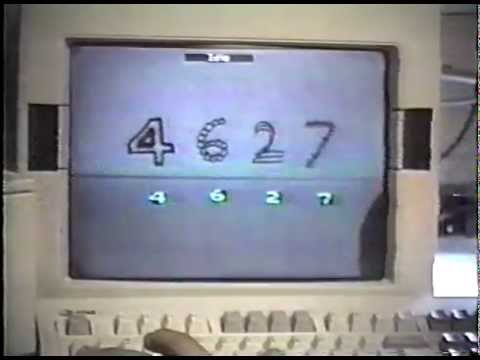

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('FwFduRA_L6Q')

In this notebook, we will try to reproduce the results of the 1989 paper, by following its approach as closely as possible. Then, we'll try to improve on it using a few more modern techniques for deep neural networks.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Retrieve and preprocess data


The original paper explains how the handwritten digit dataset was acquired and preprocessed:

> **2.1 Data Base.** The data base used to train and test the networks consists of 9298 segmented numerals digitized from handwritten zip codes that appeared on U.S. mail passing through the Buffalo, NY post office. Examples of such images are shown in Figure 1. The digits were written by many different people, using a great variety of sizes, writing styles, and instruments, with widely varying amounts of care; 7291 examples are used for training the network and 2007 are used for testing the generalization performance. One important feature of this data base is that both the training set and the testing set contain numerous examples that are ambiguous, unclassifiable, or even misclassified.
>
> **2.2 Preprocessing.** Locating the zip code on the envelope and separating each digit from its neighbors, a very hard task in itself, was performed by Postal Service contractors (Wang and Srihari 1988). At this point, the size of a digit image varies but is typically around 40 by 60 pixels. A linear transformation is then applied to make the image fit in a 16 by 16 pixel image. This transformation preserves the aspect ratio of the character, and is performed after extraneous marks in the image have been removed. Because of the linear transformation, the resulting image is not binary but has multiple gray levels, since a variable number of pixels in the original image can fall into a given pixel in the target image. The gray levels of each image are scaled and translated to fall within the range -1 to 1.

Since we don't have this exact data set, we take MNIST - a very similar data set! - and use it as an approximation of the original data set. MNIST is different in a few ways.

* has 50,000 training samples, and 10,000 test samples (compared to 7291 and 2007 respectively, for the original paper),
* and each sample is 28x28 pixels (compared to 16x16 for the original)

so to "simulate" the original, we sample without replacement the correct number of training and test samples from the complete MNIST and scale them down to the smaller 16x16 size.

---

🛑 Since our data is not exactly the same as the original paper, the numeric results may also be slightly different.

🧪To explore how sensitive the numeric result is to the specific draw of training and test samples, you can try changing the seeds in the following cell and re-running!

---

In [ ]:
# The following code is adapted from "prepro.py" in the repository.

torch.manual_seed(1337)
np.random.seed(1337)

for split in ['test', 'train']:

    data = datasets.MNIST('./data', train=split=='train', download=True)

    n = 7291 if split == 'train' else 2007
    rp = np.random.permutation(len(data))[:n]

    X = torch.full((n, 1, 16, 16), 0.0, dtype=torch.float32)
    Y = torch.full((n, 10), -1.0, dtype=torch.float32)
    for i, ix in enumerate(rp):
        I, yint = data[int(ix)]
        # PIL image -> numpy -> torch tensor -> [-1, 1] fp32
        xi = torch.from_numpy(np.array(I, dtype=np.float32)) / 127.5 - 1.0
        # add a fake batch dimension and a channel dimension of 1 or F.interpolate won't be happy
        xi = xi[None, None, ...]
        # resize to (16, 16) images with bilinear interpolation
        xi = F.interpolate(xi, (16, 16), mode='bilinear')
        X[i] = xi[0] # store

        # set the correct class to have target of +1.0
        Y[i, yint] = 1.0

    torch.save((X, Y), split + '1989.pt')

100%|██████████| 9912422/9912422 [00:00<00:00, 92820537.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28001778.51it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25814812.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12906862.31it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The training and test datasets are now saved as 'train1989.pt' and 'test1989.pt', respectively.


### Implement the original model

Now that we have data similar to the original training and evaluation data set, we can try to implement a model that is similar to the original.

The basic structure of the network design is described as follows in the original paper:

> **3.1 Input and Output.** The remainder of the recognition is entirely performed by a multilayer network. All of the connections in the network are adaptive, although heavily constrained, and are trained using backpropagation. This is in contrast with earlier work (Denker _et al._ 1989) where the first few layers of connections were hand-chosen constants implemented on a neural-network chip. The input of the network is a 16 by 16 normalized image. The output is composed of 10 units (one per class) and uses place coding.

Next, the original paper motivates the convolutional units. Here are some selected excerpts:

> **3.2 Feature Maps and Weight Sharing.** Classical work in visual pattern recognition has demonstrated the advantage of extracting local features and combining them to form higher order features. Such knowledge can be easily built into the network by forcing the hidden units to combine only local sources of information... The detection of a particular feature at any location on the input can be easily done using the "weight sharing" technique... Weight sharing not only greatly reduces the number of free parameters in the network but also can express information about the geometry
and topology of the task.

Then, it describes the architecture of the hidden layers in more detail:

> **3.3 Network Architecture.** The network is represented in Figure 2.



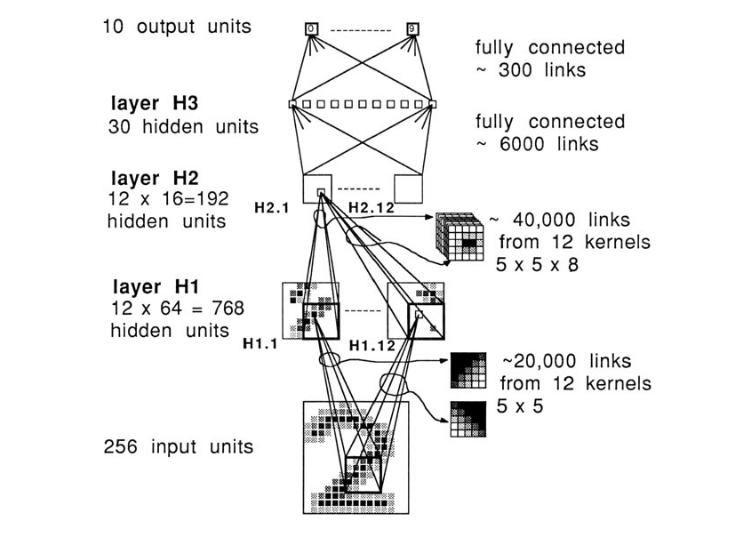

> Its architecture is a direct extension of the one proposed in LeCun (1989). The network has three hidden layers named H1, H2, and H3 respectively. Connections entering H1 and H2 are local and are heavily constrained.
>
> H1 is composed of 12 groups of 64 units arranged as 12 independent
8 by 8 feature maps. These 12 feature maps will be designated by H1.l,
H1.2, . . . , H1.12. Each unit in a feature map takes input on a 5 by 5
neighborhood on the input plane. For units in layer H1 that are one
unit apart, their receptive fields (in the input layer) are two pixels apart.
Thus, the input image is undersampled and some position information is
eliminated. A similar two-to-one undersampling occurs going from layer
H1 to H2.
>
> Of course, units in another map (say H1.4) share another set of 25
weights. Units do not share their biases (thresholds). Each unit thus has
25 input lines plus a bias. Connections extending past the boundaries of
the input plane take their input from a virtual background plane whose state is equal to a constant, predetermined background level, in our case
-1. Thus, layer H1 comprises 768 units (8 by 8 times 121, 19,968 connections (768 times 26), but only 1068 free parameters (768 biases plus 25
times 12 feature kernels) since many connections share the same weight.
>
> Layer H2 is also composed of 12 features maps. Each feature map
contains 16 units arranged in a 4 by 4 plane. As before, these feature
maps will be designated as H2.1, H2.2, . . . ,H2.12. The connection scheme
from  between H1 and H2 is quite similar to the one between the input and H1,
but slightly more complicated because H1 has multiple two-dimensional
maps. Each unit in H2 combines local information coming from 8 of the
12 different feature maps in H1. Its receptive field is composed of eight 5
by 5 neighborhoods centered around units that are at identical positions
within each of the eight maps. Thus, a unit in H2 has 200 inputs, 200
weights, and a bias. Once again, all units in a given map are constrained
to have identical weight vectors. The eight maps in H1 on which a map
in H2 takes its inputs are chosen according a scheme that will not be
described here. Connections falling off the boundaries are treated like
as in H1. To summarize, layer H2 contains 192 units (12 times 4 by 4)
and there is a total of 38,592 connections between layers H1 and H2 (192
units times 201 input lines). All these connections are controlled by only
2592 free parameters (12 feature maps times 200 weights plus 192 biases).
>
> Layer H3 has 30 units, and is fully connected to H2. The number
of connections between H2 and H3 is thus 5790 (30 times 192 plus 30
biases). The output layer has 10 units and is also fully connected to H3,
adding another 310 weights. In summary, the network has 1256 units,
64,660 connections, and 9760 independent parameters.

In modern terms, this describes a network with three hidden layers, H1, H2 and H3:

* The input layer has 16\*16 units.
* H1 has 12 5x5 convolutional kernels that move across the input with stride 2, and padding with the value -1 (for background). It is not exactly a "standard" convolutional layer, though, because the bias term is not shared (even within the same "filter"). Its output volume has dimension 12\*8\*8 and it has 1,068 parameters (768 biases + 25\*12 weights).
* H2 similarly has 12 5x5 convolutional kernels, with stride 2 and padding as in H1. However, these connect to only 8 of the 12 input planes, in a pattern that is not specified in the original paper.  Its output volume has dimension 12\*4\*4 and it has 1,068 parameters (768 biases + 25\*12 weights).
* H3 is a fully connected layer, and has 30 units fully connected to H2.
* The output layer has  10 units fully connected to H3.


More details about the network are given in Section **4 Experimental Environment**:

The activation function at each unit (including output units) is specified as tanh:

> The nonlinear function used at each node was a scaled hyperbolic tangent.

The loss function is mean squared error (which is not typically used for classification anymore!):

> The output cost function was the mean squared error.

The weight initialization scheme is specified as follows:

> Before training, the weights were initialized with random values using a uniform distribution between -2.4/Fi and 2.4/Fi where Fi is the
number of inputs (fan-in) of the unit to which the connection belongs.
This technique tends to keep the total inputs within the operating range
of the sigmoid.

(Karpathy assumes in his implementation that this expression is accidentally missing a square root symbol, and there should be a square root on the fan-in.)

---

🛑 Some details of the network - for example, the exact connection scheme between hidden layers - are not specified, so we have to guess at what the original authors might have done. Our guess might not be exactly right, so our numerical results might be different.


🛑 Since we don't have exactly the same random initial weights as the original paper, we won't necessarily see the exact same numeric result.

🧪To explore how sensitive the numeric result is to the specific initializations, you can try changing the seeds in the following cell and re-running!

---

In [ ]:
# The following code is adapted from "repro.py" in the repository.

class BaseNet(nn.Module):
    """ 1989 LeCun ConvNet per description in the paper """

    def __init__(self):
        super().__init__()

        # initialization as described in the paper to my best ability, but it doesn't look right...
        winit = lambda fan_in, *shape: (torch.rand(*shape) - 0.5) * 2 * 2.4 / fan_in**0.5
        macs = 0 # keep track of MACs (multiply accumulates)
        acts = 0 # keep track of number of activations

        # H1 layer parameters and their initialization
        self.H1w = nn.Parameter(winit(5*5*1, 12, 1, 5, 5))
        self.H1b = nn.Parameter(torch.zeros(12, 8, 8)) # presumably init to zero for biases
        assert self.H1w.nelement() + self.H1b.nelement() == 1068
        macs += (5*5*1) * (8*8) * 12
        acts += (8*8) * 12

        # H2 layer parameters and their initialization
        """
        H2 neurons all connect to only 8 of the 12 input planes, with an unspecified pattern
        I am going to assume the most sensible block pattern where 4 planes at a time connect
        to differently overlapping groups of 8/12 input planes. We will implement this with 3
        separate convolutions that we concatenate the results of.
        """
        self.H2w = nn.Parameter(winit(5*5*8, 12, 8, 5, 5))
        self.H2b = nn.Parameter(torch.zeros(12, 4, 4)) # presumably init to zero for biases
        assert self.H2w.nelement() + self.H2b.nelement() == 2592
        macs += (5*5*8) * (4*4) * 12
        acts += (4*4) * 12

        # H3 is a fully connected layer
        self.H3w = nn.Parameter(winit(4*4*12, 4*4*12, 30))
        self.H3b = nn.Parameter(torch.zeros(30))
        assert self.H3w.nelement() + self.H3b.nelement() == 5790
        macs += (4*4*12) * 30
        acts += 30

        # output layer is also fully connected layer
        self.outw = nn.Parameter(winit(30, 30, 10))
        self.outb = nn.Parameter(-torch.ones(10)) # 9/10 targets are -1, so makes sense to init slightly towards it
        assert self.outw.nelement() + self.outb.nelement() == 310
        macs += 30 * 10
        acts += 10

        self.macs = macs
        self.acts = acts

    def forward(self, x):

        # x has shape (1, 1, 16, 16)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        x = F.conv2d(x, self.H1w, stride=2) + self.H1b
        x = torch.tanh(x)

        # x is now shape (1, 12, 8, 8)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        slice1 = F.conv2d(x[:, 0:8], self.H2w[0:4], stride=2) # first 4 planes look at first 8 input planes
        slice2 = F.conv2d(x[:, 4:12], self.H2w[4:8], stride=2) # next 4 planes look at last 8 input planes
        slice3 = F.conv2d(torch.cat((x[:, 0:4], x[:, 8:12]), dim=1), self.H2w[8:12], stride=2) # last 4 planes are cross
        x = torch.cat((slice1, slice2, slice3), dim=1) + self.H2b
        x = torch.tanh(x)

        # x is now shape (1, 12, 4, 4)
        x = x.flatten(start_dim=1) # (1, 12*4*4)
        x = x @ self.H3w + self.H3b
        x = torch.tanh(x)

        # x is now shape (1, 30)
        x = x @ self.outw + self.outb
        x = torch.tanh(x)

         # x is finally shape (1, 10)
        return x

### Train the original model

Now, we are ready to train the model! The original paper specifies that the model is trained using SGD with one sample at a time:

> During each learning experiment, the patterns were repeatedly presented in a constant order. The weights were updated according to the so-called stochastic gradient or "on-line" procedure (updating after each presentation of a single pattern) as opposed to the "true" gradient procedure (averaging over the whole training set before updating the weights).

and that the network was trained for 23 epochs or "passes":

> After each pass through the training set, the performance was measured both on the training and on the test set. The network was trained for 23 passes through the training set (167,693 pattern presentations).

The learning rate is not specified in the original paper, and there is also no mention of learning rate decay - we assume that there was none used.

---

🛑 Since the learning rate in the original work is not specified, and we select one somewhat arbitrarily (based on a few experiments), we won't necessarily see the exact same numeric result.

🧪To explore how sensitive the numeric result is to the specific learning rate, you can try changing the learning rate in the following cell and re-running!

---

In [ ]:
# The following code is adapted from "repro.py" in the repository.

learning_rate = 0.03

# init rng
torch.manual_seed(1337)
np.random.seed(1337)
torch.use_deterministic_algorithms(True)

# init a model
model = BaseNet()
print("model stats:")
print("# params:      ", sum(p.numel() for p in model.parameters())) # in paper total is 9,760
print("# MACs:        ", model.macs)
print("# activations: ", model.acts)

# init data
Xtr, Ytr = torch.load('train1989.pt')
Xte, Yte = torch.load('test1989.pt')

# init optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

def eval_split(split):
    # eval the full train/test set, batched implementation for efficiency
    model.eval()
    X, Y = (Xtr, Ytr) if split == 'train' else (Xte, Yte)
    Yhat = model(X)
    loss = torch.mean((Y - Yhat)**2)
    err = torch.mean((Y.argmax(dim=1) != Yhat.argmax(dim=1)).float())
    print(f"eval: split {split:5s}. loss {loss.item():e}. error {err.item()*100:.2f}%. misses: {int(err.item()*Y.size(0))}")

# train
for pass_num in range(23):

    # perform one epoch of training
    model.train()
    for step_num in range(Xtr.size(0)):

        # fetch a single example into a batch of 1
        x, y = Xtr[[step_num]], Ytr[[step_num]]

        # forward the model and the loss
        yhat = model(x)
        loss = torch.mean((y - yhat)**2)

        # calculate the gradient and update the parameters
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # after epoch evaluate the train and test error / metrics
    print(pass_num + 1)
    eval_split('train')
    eval_split('test')

# save final model to file
torch.save(model.state_dict(), 'base_model.pt')

model stats:
# params:       9760
# MACs:         63660
# activations:  1000
1
eval: split train. loss 6.303316e-02. error 9.00%. misses: 656
eval: split test . loss 6.877646e-02. error 10.26%. misses: 205
2
eval: split train. loss 4.681426e-02. error 6.76%. misses: 492
eval: split test . loss 5.422365e-02. error 8.37%. misses: 168
3
eval: split train. loss 3.861549e-02. error 5.39%. misses: 392
eval: split test . loss 4.878836e-02. error 7.57%. misses: 152
4
eval: split train. loss 3.224046e-02. error 4.46%. misses: 325
eval: split test . loss 4.432748e-02. error 7.27%. misses: 145
5
eval: split train. loss 2.540217e-02. error 3.47%. misses: 252
eval: split test . loss 4.001104e-02. error 5.68%. misses: 114
6
eval: split train. loss 2.219577e-02. error 3.15%. misses: 229
eval: split test . loss 3.938299e-02. error 5.68%. misses: 114
7
eval: split train. loss 1.829746e-02. error 2.55%. misses: 185
eval: split test . loss 3.681788e-02. error 5.33%. misses: 107
8
eval: split train. loss 

Our error performance is slightly better than reported in the original 1989 paper, but we don't expect to get exactly the same numerical results - we don't have exactly the same data, or random initial weights, and some other details of model training are also not exactly identical.

In 1989, this model took about 3 days to train on a SUN-4/260 workstation. Today, on a Google Colab hosted CPU runtime (i.e. a VM with 2 Intel(R) Xeon(R) CPUs @ 2.20GHz), it took about 7 minutes.



### Visualize misclassified samples for original model

In [ ]:
# The following code is adapted from "vis.ipynb" in the repository.

model.eval()

def grid_mistakes(X, Y):

    plt.figure(figsize=(14, 4))
    ishow, nshow = 0, 14
    for ix in range(X.size(0)):
        x, y = X[[ix]], Y[[ix]]
        yhat = model(x)
        yi = y.argmax()
        yhati = yhat.argmax()
        if yi != yhati:
            plt.subplot(2, 7, ishow+1)
            plt.imshow(x[0,0], cmap='gray')
            plt.title(f'gt={yi}, pred={yhati}')
            plt.axis('off')
            ishow += 1
            if ishow >= nshow:
                break

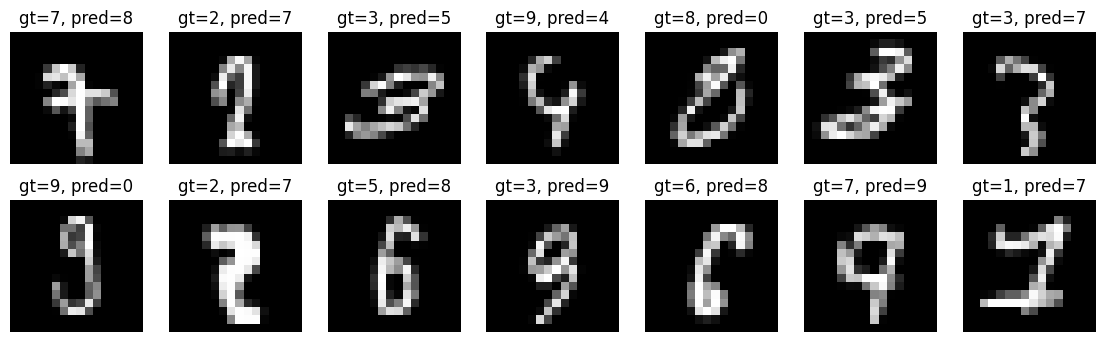

In [ ]:
# The following code is adapted from "vis.ipynb" in the repository.

grid_mistakes(Xtr, Ytr) # training set mistakes

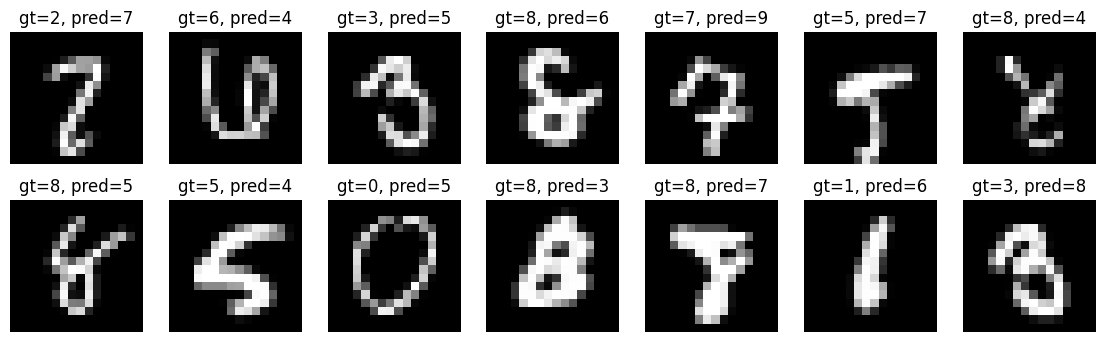

In [ ]:
# The following code is adapted from "vis.ipynb" in the repository.

grid_mistakes(Xte, Yte) # test set mistakes

### Model with updated loss function

The 1989-era model had a slightly strange (by our "modern" standard) output layer, for a multi-class classification problem -

* there is a tanh activation on the output units, which maps the output for each of the 10 outputs to the range -1 to 1.
* and then there is a mean squared error loss function on the outputs.

We will "update" the model by removing the tanh activation on the output units, and then using the typical (for a classification problem) [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).

I also noticed that when I ran this modified model, the loss seemed to "blow up" suggesting a too-high learning rate - so I reduced the learning rate from 0.03 to 0.01.

In [ ]:

class ModernLossNet(nn.Module):

    def __init__(self):
        super().__init__()

        # initialization as described in the paper to my best ability, but it doesn't look right...
        winit = lambda fan_in, *shape: (torch.rand(*shape) - 0.5) * 2 * 2.4 / fan_in**0.5
        macs = 0 # keep track of MACs (multiply accumulates)
        acts = 0 # keep track of number of activations

        # H1 layer parameters and their initialization
        self.H1w = nn.Parameter(winit(5*5*1, 12, 1, 5, 5))
        self.H1b = nn.Parameter(torch.zeros(12, 8, 8)) # presumably init to zero for biases
        assert self.H1w.nelement() + self.H1b.nelement() == 1068
        macs += (5*5*1) * (8*8) * 12
        acts += (8*8) * 12

        # H2 layer parameters and their initialization
        """
        H2 neurons all connect to only 8 of the 12 input planes, with an unspecified pattern
        I am going to assume the most sensible block pattern where 4 planes at a time connect
        to differently overlapping groups of 8/12 input planes. We will implement this with 3
        separate convolutions that we concatenate the results of.
        """
        self.H2w = nn.Parameter(winit(5*5*8, 12, 8, 5, 5))
        self.H2b = nn.Parameter(torch.zeros(12, 4, 4)) # presumably init to zero for biases
        assert self.H2w.nelement() + self.H2b.nelement() == 2592
        macs += (5*5*8) * (4*4) * 12
        acts += (4*4) * 12

        # H3 is a fully connected layer
        self.H3w = nn.Parameter(winit(4*4*12, 4*4*12, 30))
        self.H3b = nn.Parameter(torch.zeros(30))
        assert self.H3w.nelement() + self.H3b.nelement() == 5790
        macs += (4*4*12) * 30
        acts += 30

        # output layer is also fully connected layer
        self.outw = nn.Parameter(winit(30, 30, 10))
        self.outb = nn.Parameter(-torch.ones(10)) # 9/10 targets are -1, so makes sense to init slightly towards it
        assert self.outw.nelement() + self.outb.nelement() == 310
        macs += 30 * 10
        acts += 10

        self.macs = macs
        self.acts = acts

    def forward(self, x):

        # x has shape (1, 1, 16, 16)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        x = F.conv2d(x, self.H1w, stride=2) + self.H1b
        x = torch.tanh(x)

        # x is now shape (1, 12, 8, 8)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        slice1 = F.conv2d(x[:, 0:8], self.H2w[0:4], stride=2) # first 4 planes look at first 8 input planes
        slice2 = F.conv2d(x[:, 4:12], self.H2w[4:8], stride=2) # next 4 planes look at last 8 input planes
        slice3 = F.conv2d(torch.cat((x[:, 0:4], x[:, 8:12]), dim=1), self.H2w[8:12], stride=2) # last 4 planes are cross
        x = torch.cat((slice1, slice2, slice3), dim=1) + self.H2b
        x = torch.tanh(x)

        # x is now shape (1, 12, 4, 4)
        x = x.flatten(start_dim=1) # (1, 12*4*4)
        x = x @ self.H3w + self.H3b
        x = torch.tanh(x)

        # x is now shape (1, 30)
        x = x @ self.outw + self.outb
        # Note: we deleted the tanh activation here!

         # x is finally shape (1, 10)
        return x

In [ ]:

# Note: with the original learning rate, the SGD did not seem to learn well
# so I changed it to a smaller learning rate
learning_rate = 0.01

# init rng
torch.manual_seed(1337)
np.random.seed(1337)
torch.use_deterministic_algorithms(True)

# init a model
model = ModernLossNet()
print("model stats:")
print("# params:      ", sum(p.numel() for p in model.parameters())) # in paper total is 9,760
print("# MACs:        ", model.macs)
print("# activations: ", model.acts)

# init data
Xtr, Ytr = torch.load('train1989.pt')
Xte, Yte = torch.load('test1989.pt')

# init optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

def eval_split(split):
    # eval the full train/test set, batched implementation for efficiency
    model.eval()
    X, Y = (Xtr, Ytr) if split == 'train' else (Xte, Yte)
    Yhat = model(X)
    # Note: the updated loss function!
    loss = F.cross_entropy(Yhat, Y.argmax(dim=1))
    err = torch.mean((Y.argmax(dim=1) != Yhat.argmax(dim=1)).float())
    print(f"eval: split {split:5s}. loss {loss.item():e}. error {err.item()*100:.2f}%. misses: {int(err.item()*Y.size(0))}")

# train
for pass_num in range(23):

    # perform one epoch of training
    model.train()
    for step_num in range(Xtr.size(0)):

        # fetch a single example into a batch of 1
        x, y = Xtr[[step_num]], Ytr[[step_num]]

        # forward the model and the loss
        yhat = model(x)
        loss = F.cross_entropy(yhat, y.argmax(dim=1))
        # Note: the updated loss function!

        # calculate the gradient and update the parameters
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # after epoch epoch evaluate the train and test error / metrics
    print(pass_num + 1)
    eval_split('train')
    eval_split('test')

# save final model to file
torch.save(model.state_dict(), 'crossentropy_model.pt')

model stats:
# params:       9760
# MACs:         63660
# activations:  1000
1
eval: split train. loss 2.547408e-01. error 7.57%. misses: 552
eval: split test . loss 2.883549e-01. error 8.67%. misses: 174
2
eval: split train. loss 1.863126e-01. error 5.76%. misses: 419
eval: split test . loss 2.397452e-01. error 7.42%. misses: 149
3
eval: split train. loss 1.585573e-01. error 4.58%. misses: 333
eval: split test . loss 2.222673e-01. error 6.88%. misses: 138
4
eval: split train. loss 1.367183e-01. error 4.14%. misses: 301
eval: split test . loss 2.259786e-01. error 7.22%. misses: 144
5
eval: split train. loss 1.080973e-01. error 3.46%. misses: 252
eval: split test . loss 2.042281e-01. error 6.08%. misses: 122
6
eval: split train. loss 9.097695e-02. error 3.07%. misses: 223
eval: split test . loss 2.100919e-01. error 6.38%. misses: 128
7
eval: split train. loss 6.656891e-02. error 2.02%. misses: 146
eval: split test . loss 1.925825e-01. error 5.78%. misses: 115
8
eval: split train. loss 5

The test performance is similar, maybe a little worse - since I reduced the learning rate, I may need to increase the number of passes to compensate.

But, we are now seeing zero error on the training set. We may be overfitting.

Fortunately, we have some "tricks" for improving the performance of deep neural networks! We can try -

* a more modern optimizer (i.e. improve over the stochastic gradient descent with fixed learning rate)
* data augmentation
* a regularization technique, like dropout

and see if they improve our performance, while still keeping the basic model - number of layers, number of units, size of each convolutional filter - the same.

### Training with a better optimizer

The original model is trained using stochastic gradient descent on a single sample at a time, with a fixed learning rate.

To see if a more sophisticated optimizer will help, we will try to train the same model with a version of the Adam optimizer. Adam is a combination of two gradient descent "variations" we have discussed previously:

* Momentum - uses a velocity vector that accumulates gradient of past steps.
* RMSProp - normalizes parameter update using per-parameter EWMA of square of gradient.

and it is often used as a starting point when training deep neural networks.

We are also going to "decay" the learning rate as we iterate over the number of epochs.

And, we will also double the number of training epochs from 23 to 46.

In [ ]:
# The following code is adapted from "modern.py" in the repository.

# Note: different initial learning rate
learning_rate = 3e-4

# init rng
torch.manual_seed(1337)
np.random.seed(1337)
torch.use_deterministic_algorithms(True)

# init a model
model = ModernLossNet()
print("model stats:")
print("# params:      ", sum(p.numel() for p in model.parameters())) # in paper total is 9,760
print("# MACs:        ", model.macs)
print("# activations: ", model.acts)

# init data
Xtr, Ytr = torch.load('train1989.pt')
Xte, Yte = torch.load('test1989.pt')

# init optimizer
# Note: use the the AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

def eval_split(split):
    # eval the full train/test set, batched implementation for efficiency
    model.eval()
    X, Y = (Xtr, Ytr) if split == 'train' else (Xte, Yte)
    Yhat = model(X)
    loss = F.cross_entropy(Yhat, Y.argmax(dim=1))
    err = torch.mean((Y.argmax(dim=1) != Yhat.argmax(dim=1)).float())
    print(f"eval: split {split:5s}. loss {loss.item():e}. error {err.item()*100:.2f}%. misses: {int(err.item()*Y.size(0))}")

# Note: increase number of training passes
for pass_num in range(46):

    # Note: also implement learning rate decay
    alpha = pass_num / 45
    for g in optimizer.param_groups:
        g['lr'] = (1 - alpha) * learning_rate + alpha * (learning_rate / 3)

    # perform one epoch of training
    model.train()
    for step_num in range(Xtr.size(0)):

        # fetch a single example into a batch of 1
        x, y = Xtr[[step_num]], Ytr[[step_num]]

        # forward the model and the loss
        yhat = model(x)
        loss = F.cross_entropy(yhat, y.argmax(dim=1))

        # calculate the gradient and update the parameters
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # after epoch epoch evaluate the train and test error / metrics
    print(pass_num + 1)
    eval_split('train')
    eval_split('test')

# save final model to file
torch.save(model.state_dict(), 'adam_model.pt')

model stats:
# params:       9760
# MACs:         63660
# activations:  1000
1
eval: split train. loss 3.553850e-01. error 10.08%. misses: 734
eval: split test . loss 3.418252e-01. error 10.31%. misses: 206
2
eval: split train. loss 2.473212e-01. error 7.20%. misses: 524
eval: split test . loss 2.514379e-01. error 7.22%. misses: 144
3
eval: split train. loss 1.973256e-01. error 5.58%. misses: 406
eval: split test . loss 2.185514e-01. error 6.13%. misses: 122
4
eval: split train. loss 1.690831e-01. error 4.77%. misses: 347
eval: split test . loss 2.048475e-01. error 5.73%. misses: 115
5
eval: split train. loss 1.465219e-01. error 4.32%. misses: 314
eval: split test . loss 1.939704e-01. error 5.28%. misses: 105
6
eval: split train. loss 1.272241e-01. error 3.72%. misses: 271
eval: split test . loss 1.844373e-01. error 5.18%. misses: 104
7
eval: split train. loss 1.110661e-01. error 3.13%. misses: 228
eval: split test . loss 1.769724e-01. error 4.98%. misses: 99
8
eval: split train. loss 

We seem to have improved the test performance - it is now below 4% error. We are still achieving 0 error on the training set, so we remain concerned about potential overfitting.

### Training with data augmentation

To combat potential overfitting, we can add some basic data augmentation. When we load a training sample, we will randomly shift it by up to one pixel in the vertical and/or horizontal directions.

We also increase the number of passes again to 60, since data augmentation (1) increases the effective "size" of the training set, and (2) also adds some "noise" to the training process.

In [ ]:
# The following code is adapted from "modern.py" in the repository.

class ModernDataAugNet(nn.Module):

    def __init__(self):
        super().__init__()

        # initialization as described in the paper to my best ability, but it doesn't look right...
        winit = lambda fan_in, *shape: (torch.rand(*shape) - 0.5) * 2 * 2.4 / fan_in**0.5
        macs = 0 # keep track of MACs (multiply accumulates)
        acts = 0 # keep track of number of activations

        # H1 layer parameters and their initialization
        self.H1w = nn.Parameter(winit(5*5*1, 12, 1, 5, 5))
        self.H1b = nn.Parameter(torch.zeros(12, 8, 8)) # presumably init to zero for biases
        macs += (5*5*1) * (8*8) * 12
        acts += (8*8) * 12

        # H2 layer parameters and their initialization
        """
        H2 neurons all connect to only 8 of the 12 input planes, with an unspecified pattern
        I am going to assume the most sensible block pattern where 4 planes at a time connect
        to differently overlapping groups of 8/12 input planes. We will implement this with 3
        separate convolutions that we concatenate the results of.
        """
        self.H2w = nn.Parameter(winit(5*5*8, 12, 8, 5, 5))
        self.H2b = nn.Parameter(torch.zeros(12, 4, 4)) # presumably init to zero for biases
        macs += (5*5*8) * (4*4) * 12
        acts += (4*4) * 12

        # H3 is a fully connected layer
        self.H3w = nn.Parameter(winit(4*4*12, 4*4*12, 30))
        self.H3b = nn.Parameter(torch.zeros(30))
        macs += (4*4*12) * 30
        acts += 30

        # output layer is also fully connected layer
        self.outw = nn.Parameter(winit(30, 30, 10))
        self.outb = nn.Parameter(torch.zeros(10))
        macs += 30 * 10
        acts += 10

        self.macs = macs
        self.acts = acts

    def forward(self, x):

        # Note: basic data augmentation by 1 pixel along x/y directions
        if self.training:
            shift_x, shift_y = np.random.randint(-1, 2, size=2)
            x = torch.roll(x, (shift_x, shift_y), (2, 3))

        # x has shape (1, 1, 16, 16)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        x = F.conv2d(x, self.H1w, stride=2) + self.H1b
        x = torch.tanh(x)

        # x is now shape (1, 12, 8, 8)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        slice1 = F.conv2d(x[:, 0:8], self.H2w[0:4], stride=2) # first 4 planes look at first 8 input planes
        slice2 = F.conv2d(x[:, 4:12], self.H2w[4:8], stride=2) # next 4 planes look at last 8 input planes
        slice3 = F.conv2d(torch.cat((x[:, 0:4], x[:, 8:12]), dim=1), self.H2w[8:12], stride=2) # last 4 planes are cross
        x = torch.cat((slice1, slice2, slice3), dim=1) + self.H2b
        x = torch.tanh(x)

        # x is now shape (1, 12, 4, 4)
        x = x.flatten(start_dim=1) # (1, 12*4*4)
        x = x @ self.H3w + self.H3b
        x = torch.tanh(x)

        # x is now shape (1, 30)
        x = x @ self.outw + self.outb

         # x is finally shape (1, 10)
        return x

In [ ]:
# The following code is adapted from "modern.py" in the repository.

learning_rate = 3e-4

# init rng
torch.manual_seed(1337)
np.random.seed(1337)
torch.use_deterministic_algorithms(True)

# init a model
model = ModernDataAugNet()
print("model stats:")
print("# params:      ", sum(p.numel() for p in model.parameters())) # in paper total is 9,760
print("# MACs:        ", model.macs)
print("# activations: ", model.acts)

# init data
Xtr, Ytr = torch.load('train1989.pt')
Xte, Yte = torch.load('test1989.pt')

# init optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

def eval_split(split):
    # eval the full train/test set, batched implementation for efficiency
    model.eval()
    X, Y = (Xtr, Ytr) if split == 'train' else (Xte, Yte)
    Yhat = model(X)
    loss = F.cross_entropy(Yhat, Y.argmax(dim=1))
    err = torch.mean((Y.argmax(dim=1) != Yhat.argmax(dim=1)).float())
    print(f"eval: split {split:5s}. loss {loss.item():e}. error {err.item()*100:.2f}%. misses: {int(err.item()*Y.size(0))}")

# train
for pass_num in range(60):

    # learning rate decay
    alpha = pass_num / 79
    for g in optimizer.param_groups:
        g['lr'] = (1 - alpha) * learning_rate + alpha * (learning_rate / 3)

    # perform one epoch of training
    model.train()
    for step_num in range(Xtr.size(0)):

        # fetch a single example into a batch of 1
        x, y = Xtr[[step_num]], Ytr[[step_num]]

        # forward the model and the loss
        yhat = model(x)
        loss = F.cross_entropy(yhat, y.argmax(dim=1))

        # calculate the gradient and update the parameters
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # after epoch epoch evaluate the train and test error / metrics
    print(pass_num + 1)
    eval_split('train')
    eval_split('test')

# save final model to file
torch.save(model.state_dict(), 'dataug_model.pt')

model stats:
# params:       9760
# MACs:         63660
# activations:  1000
1
eval: split train. loss 5.288423e-01. error 13.48%. misses: 982
eval: split test . loss 5.376812e-01. error 13.65%. misses: 274
2
eval: split train. loss 3.618094e-01. error 9.74%. misses: 710
eval: split test . loss 3.622440e-01. error 10.21%. misses: 204
3
eval: split train. loss 2.770010e-01. error 7.78%. misses: 567
eval: split test . loss 2.691664e-01. error 7.77%. misses: 155
4
eval: split train. loss 2.191166e-01. error 6.32%. misses: 460
eval: split test . loss 2.131962e-01. error 5.88%. misses: 117
5
eval: split train. loss 1.949559e-01. error 5.71%. misses: 416
eval: split test . loss 2.028036e-01. error 6.13%. misses: 122
6
eval: split train. loss 1.760966e-01. error 5.09%. misses: 371
eval: split test . loss 1.767326e-01. error 5.28%. misses: 105
7
eval: split train. loss 1.579356e-01. error 4.69%. misses: 341
eval: split test . loss 1.632146e-01. error 5.08%. misses: 102
8
eval: split train. los

Data augmentation - used in combination with our other improvements - seems to help a lot! Our test error is now comfortably under 3%.

### Model with dropout (and ReLU)

Another tools to combat overfitting is regularization. To regularize the network, we add a dropout layer with 0.25 probability just before the layer with the largest number of parameters (H3).

Because dropout zeros some activations, it doesn’t make as much sense to use it with tanh activations that map outputs to the range -1 to 1. So, we also change the activations throughout the hidden layers from tanh to ReLU.

Finally, we increase the number of training epochs again to 80, since dropout introduces some more noise in the training process.

In [ ]:
# The following code is adapted from "modern.py" in the repository.

class ModernDropoutNet(nn.Module):

    def __init__(self):
        super().__init__()

        # initialization as described in the paper to my best ability, but it doesn't look right...
        winit = lambda fan_in, *shape: (torch.rand(*shape) - 0.5) * 2 * 2.4 / fan_in**0.5
        macs = 0 # keep track of MACs (multiply accumulates)
        acts = 0 # keep track of number of activations

        # H1 layer parameters and their initialization
        self.H1w = nn.Parameter(winit(5*5*1, 12, 1, 5, 5))
        self.H1b = nn.Parameter(torch.zeros(12, 8, 8)) # presumably init to zero for biases
        macs += (5*5*1) * (8*8) * 12
        acts += (8*8) * 12

        # H2 layer parameters and their initialization
        """
        H2 neurons all connect to only 8 of the 12 input planes, with an unspecified pattern
        I am going to assume the most sensible block pattern where 4 planes at a time connect
        to differently overlapping groups of 8/12 input planes. We will implement this with 3
        separate convolutions that we concatenate the results of.
        """
        self.H2w = nn.Parameter(winit(5*5*8, 12, 8, 5, 5))
        self.H2b = nn.Parameter(torch.zeros(12, 4, 4)) # presumably init to zero for biases
        macs += (5*5*8) * (4*4) * 12
        acts += (4*4) * 12

        # H3 is a fully connected layer
        self.H3w = nn.Parameter(winit(4*4*12, 4*4*12, 30))
        self.H3b = nn.Parameter(torch.zeros(30))
        macs += (4*4*12) * 30
        acts += 30

        # output layer is also fully connected layer
        self.outw = nn.Parameter(winit(30, 30, 10))
        self.outb = nn.Parameter(torch.zeros(10))
        macs += 30 * 10
        acts += 10

        self.macs = macs
        self.acts = acts

    def forward(self, x):

        # poor man's data augmentation by 1 pixel along x/y directions
        if self.training:
            shift_x, shift_y = np.random.randint(-1, 2, size=2)
            x = torch.roll(x, (shift_x, shift_y), (2, 3))

        # x has shape (1, 1, 16, 16)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        x = F.conv2d(x, self.H1w, stride=2) + self.H1b
        x = torch.relu(x) # Note: ReLU activation!

        # x is now shape (1, 12, 8, 8)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        slice1 = F.conv2d(x[:, 0:8], self.H2w[0:4], stride=2) # first 4 planes look at first 8 input planes
        slice2 = F.conv2d(x[:, 4:12], self.H2w[4:8], stride=2) # next 4 planes look at last 8 input planes
        slice3 = F.conv2d(torch.cat((x[:, 0:4], x[:, 8:12]), dim=1), self.H2w[8:12], stride=2) # last 4 planes are cross
        x = torch.cat((slice1, slice2, slice3), dim=1) + self.H2b
        x = torch.relu(x) # Note: ReLU activation!

        # x is now shape (1, 12, 4, 4)
        x = x.flatten(start_dim=1) # (1, 12*4*4)
        x = x @ self.H3w + self.H3b
        x = torch.relu(x) # Note: ReLU activation!
        x = F.dropout(x, p=0.25, training=self.training) # Note: dropout layer!


        # x is now shape (1, 30)
        x = x @ self.outw + self.outb

         # x is finally shape (1, 10)
        return x

In [ ]:
# The following code is adapted from "modern.py" in the repository.

learning_rate = 3e-4

# init rng
torch.manual_seed(1337)
np.random.seed(1337)
torch.use_deterministic_algorithms(True)

# init a model
model = ModernDropoutNet()
print("model stats:")
print("# params:      ", sum(p.numel() for p in model.parameters())) # in paper total is 9,760
print("# MACs:        ", model.macs)
print("# activations: ", model.acts)

# init data
Xtr, Ytr = torch.load('train1989.pt')
Xte, Yte = torch.load('test1989.pt')

# init optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

def eval_split(split):
    # eval the full train/test set, batched implementation for efficiency
    model.eval()
    X, Y = (Xtr, Ytr) if split == 'train' else (Xte, Yte)
    Yhat = model(X)
    loss = F.cross_entropy(Yhat, Y.argmax(dim=1))
    err = torch.mean((Y.argmax(dim=1) != Yhat.argmax(dim=1)).float())
    print(f"eval: split {split:5s}. loss {loss.item():e}. error {err.item()*100:.2f}%. misses: {int(err.item()*Y.size(0))}")

# train
for pass_num in range(80):

    # learning rate decay
    alpha = pass_num / 79
    for g in optimizer.param_groups:
        g['lr'] = (1 - alpha) * learning_rate + alpha * (learning_rate / 3)

    # perform one epoch of training
    model.train()
    for step_num in range(Xtr.size(0)):

        # fetch a single example into a batch of 1
        x, y = Xtr[[step_num]], Ytr[[step_num]]

        # forward the model and the loss
        yhat = model(x)
        loss = F.cross_entropy(yhat, y.argmax(dim=1))

        # calculate the gradient and update the parameters
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # after epoch epoch evaluate the train and test error / metrics
    print(pass_num + 1)
    eval_split('train')
    eval_split('test')

# save final model to file
torch.save(model.state_dict(), 'dropout_model.pt')

model stats:
# params:       9760
# MACs:         63660
# activations:  1000
1
eval: split train. loss 5.223247e-01. error 13.59%. misses: 991
eval: split test . loss 5.147547e-01. error 13.25%. misses: 266
2
eval: split train. loss 3.238891e-01. error 8.53%. misses: 622
eval: split test . loss 3.289565e-01. error 8.92%. misses: 179
3
eval: split train. loss 2.529212e-01. error 6.75%. misses: 491
eval: split test . loss 2.521613e-01. error 6.93%. misses: 139
4
eval: split train. loss 1.924911e-01. error 5.72%. misses: 417
eval: split test . loss 1.910119e-01. error 5.48%. misses: 109
5
eval: split train. loss 1.814650e-01. error 5.50%. misses: 401
eval: split test . loss 1.837532e-01. error 5.58%. misses: 112
6
eval: split train. loss 1.666141e-01. error 5.27%. misses: 384
eval: split test . loss 1.673810e-01. error 5.13%. misses: 102
7
eval: split train. loss 1.402711e-01. error 4.54%. misses: 331
eval: split test . loss 1.433306e-01. error 4.43%. misses: 89
8
eval: split train. loss 

### Original model with larger data set

We have used a series of modern "tricks" to improve the performance of the 1989 model, without changing its basic structure.

But one of our best "tricks" for improving the performance of large neural networks is to increase the size and/or quality of the data on which the model is trained.

It is interesting to see what performance we could have achieved in 1989 without any of those other "tricks" (some of which were not yet understood or widely used) - just using more data.


In the following cell, we preprocess the full MNIST dataset - 50,000 training samples and 10,000 test samples, rather than the 7291 and 2007 samples used in 1989 - to downsample them from 28x28 to 16x16.

Then, we'll train that original 1989 model - *without* any of the changes we tried earlier - on this larger data set.

In [ ]:
# The following code is adapted from "prepro.py" in the repository.

torch.manual_seed(1337)
np.random.seed(1337)

for split in {'train', 'test'}:

    data = datasets.MNIST('./data', train=split=='train', download=True)

    # Note: use full size data set
    n = 50000 if split == 'train' else 10000
    rp = np.random.permutation(len(data))[:n]

    X = torch.full((n, 1, 16, 16), 0.0, dtype=torch.float32)
    Y = torch.full((n, 10), -1.0, dtype=torch.float32)
    for i, ix in enumerate(rp):
        I, yint = data[int(ix)]
        # PIL image -> numpy -> torch tensor -> [-1, 1] fp32
        xi = torch.from_numpy(np.array(I, dtype=np.float32)) / 127.5 - 1.0
        # add a fake batch dimension and a channel dimension of 1 or F.interpolate won't be happy
        xi = xi[None, None, ...]
        # resize to (16, 16) images with bilinear interpolation
        xi = F.interpolate(xi, (16, 16), mode='bilinear')
        X[i] = xi[0] # store

        # set the correct class to have target of +1.0
        Y[i, yint] = 1.0

    torch.save((X, Y), split + 'full.pt')

100%|██████████| 9912422/9912422 [00:00<00:00, 71638042.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9457814.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39912114.62it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 9734557.37it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
learning_rate = 0.03

# init rng
torch.manual_seed(1337)
np.random.seed(1337)
torch.use_deterministic_algorithms(True)

# init a model
model = BaseNet()
print("model stats:")
print("# params:      ", sum(p.numel() for p in model.parameters())) # in paper total is 9,760
print("# MACs:        ", model.macs)
print("# activations: ", model.acts)

# init data
Xtr, Ytr = torch.load('trainfull.pt')
Xte, Yte = torch.load('testfull.pt')

# init optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

def eval_split(split):
    # eval the full train/test set, batched implementation for efficiency
    model.eval()
    X, Y = (Xtr, Ytr) if split == 'train' else (Xte, Yte)
    Yhat = model(X)
    loss = torch.mean((Y - Yhat)**2)
    err = torch.mean((Y.argmax(dim=1) != Yhat.argmax(dim=1)).float())
    print(f"eval: split {split:5s}. loss {loss.item():e}. error {err.item()*100:.2f}%. misses: {int(err.item()*Y.size(0))}")

# train
for pass_num in range(80):

    # perform one epoch of training
    model.train()
    for step_num in range(Xtr.size(0)):

        # fetch a single example into a batch of 1
        x, y = Xtr[[step_num]], Ytr[[step_num]]

        # forward the model and the loss
        yhat = model(x)
        loss = torch.mean((y - yhat)**2)

        # calculate the gradient and update the parameters
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # after epoch epoch evaluate the train and test error / metrics
    print(pass_num + 1)
    eval_split('train')
    eval_split('test')

# save final model to file
torch.save(model.state_dict(), 'base_model_data.pt')

model stats:
# params:       9760
# MACs:         63660
# activations:  1000
1
eval: split train. loss 3.372094e-02. error 5.11%. misses: 2555
eval: split test . loss 3.295155e-02. error 5.04%. misses: 504
2
eval: split train. loss 2.436154e-02. error 3.58%. misses: 1790
eval: split test . loss 2.541548e-02. error 3.73%. misses: 373
3
eval: split train. loss 2.174933e-02. error 3.24%. misses: 1620
eval: split test . loss 2.369628e-02. error 3.57%. misses: 357
4
eval: split train. loss 2.092772e-02. error 3.16%. misses: 1579
eval: split test . loss 2.357459e-02. error 3.49%. misses: 348
5
eval: split train. loss 1.849931e-02. error 2.74%. misses: 1369
eval: split test . loss 2.216178e-02. error 3.43%. misses: 342
6
eval: split train. loss 1.842882e-02. error 2.75%. misses: 1372
eval: split test . loss 2.217882e-02. error 3.43%. misses: 342
7
eval: split train. loss 1.781441e-02. error 2.66%. misses: 1329
eval: split test . loss 2.282108e-02. error 3.53%. misses: 353
8
eval: split train.

Using the original 1989 model,

* with the "weird" MSE loss function,
* tanh activation,
* "plain" stochastic gradient descent with a fixed learning rate,
* and no regularization,

we still see a very respectable increase in performance just by training on more data (and since there is more data, adding more training passes.)

This would have substantially increased the training time in 1989 - the original model trained on 7291 training samples took 3 days to train, and this training set is about 7x that size - but the inference time would not have been affected.

### Modern model with larger data set

Finally, let's see how our "modern" updated neural network does when trained on the larger dataset - 50,000 training samples.

In [ ]:
class ModernNet(nn.Module):

    def __init__(self):
        super().__init__()

        # initialization as described in the paper to my best ability, but it doesn't look right...
        winit = lambda fan_in, *shape: (torch.rand(*shape) - 0.5) * 2 * 2.4 / fan_in**0.5
        macs = 0 # keep track of MACs (multiply accumulates)
        acts = 0 # keep track of number of activations

        # H1 layer parameters and their initialization
        self.H1w = nn.Parameter(winit(5*5*1, 12, 1, 5, 5))
        self.H1b = nn.Parameter(torch.zeros(12, 8, 8)) # presumably init to zero for biases
        macs += (5*5*1) * (8*8) * 12
        acts += (8*8) * 12

        # H2 layer parameters and their initialization
        """
        H2 neurons all connect to only 8 of the 12 input planes, with an unspecified pattern
        I am going to assume the most sensible block pattern where 4 planes at a time connect
        to differently overlapping groups of 8/12 input planes. We will implement this with 3
        separate convolutions that we concatenate the results of.
        """
        self.H2w = nn.Parameter(winit(5*5*8, 12, 8, 5, 5))
        self.H2b = nn.Parameter(torch.zeros(12, 4, 4)) # presumably init to zero for biases
        macs += (5*5*8) * (4*4) * 12
        acts += (4*4) * 12

        # H3 is a fully connected layer
        self.H3w = nn.Parameter(winit(4*4*12, 4*4*12, 30))
        self.H3b = nn.Parameter(torch.zeros(30))
        macs += (4*4*12) * 30
        acts += 30

        # output layer is also fully connected layer
        self.outw = nn.Parameter(winit(30, 30, 10))
        self.outb = nn.Parameter(torch.zeros(10))
        macs += 30 * 10
        acts += 10

        self.macs = macs
        self.acts = acts

    def forward(self, x):

        # poor man's data augmentation by 1 pixel along x/y directions
        if self.training:
            shift_x, shift_y = np.random.randint(-1, 2, size=2)
            x = torch.roll(x, (shift_x, shift_y), (2, 3))

        # x has shape (1, 1, 16, 16)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        x = F.conv2d(x, self.H1w, stride=2) + self.H1b
        x = torch.relu(x) # Note: ReLU activation!

        # x is now shape (1, 12, 8, 8)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        slice1 = F.conv2d(x[:, 0:8], self.H2w[0:4], stride=2) # first 4 planes look at first 8 input planes
        slice2 = F.conv2d(x[:, 4:12], self.H2w[4:8], stride=2) # next 4 planes look at last 8 input planes
        slice3 = F.conv2d(torch.cat((x[:, 0:4], x[:, 8:12]), dim=1), self.H2w[8:12], stride=2) # last 4 planes are cross
        x = torch.cat((slice1, slice2, slice3), dim=1) + self.H2b
        x = torch.relu(x) # Note: ReLU activation!

        # x is now shape (1, 12, 4, 4)
        x = x.flatten(start_dim=1) # (1, 12*4*4)
        x = x @ self.H3w + self.H3b
        x = torch.relu(x) # Note: ReLU activation!
        x = F.dropout(x, p=0.25, training=self.training) # Note: dropout layer!


        # x is now shape (1, 30)
        x = x @ self.outw + self.outb

         # x is finally shape (1, 10)
        return x

In [ ]:
# The following code is adapted from "modern.py" in the repository.

learning_rate = 3e-4

# init rng
torch.manual_seed(1337)
np.random.seed(1337)
torch.use_deterministic_algorithms(True)

# init a model
model = ModernNet()
print("model stats:")
print("# params:      ", sum(p.numel() for p in model.parameters())) # in paper total is 9,760
print("# MACs:        ", model.macs)
print("# activations: ", model.acts)

# init data
Xtr, Ytr = torch.load('trainfull.pt')
Xte, Yte = torch.load('testfull.pt')

# init optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

def eval_split(split):
    # eval the full train/test set, batched implementation for efficiency
    model.eval()
    X, Y = (Xtr, Ytr) if split == 'train' else (Xte, Yte)
    Yhat = model(X)
    loss = F.cross_entropy(Yhat, Y.argmax(dim=1))
    err = torch.mean((Y.argmax(dim=1) != Yhat.argmax(dim=1)).float())
    print(f"eval: split {split:5s}. loss {loss.item():e}. error {err.item()*100:.2f}%. misses: {int(err.item()*Y.size(0))}")

# train
for pass_num in range(80):

    # learning rate decay
    alpha = pass_num / 79
    for g in optimizer.param_groups:
        g['lr'] = (1 - alpha) * learning_rate + alpha * (learning_rate / 3)

    # perform one epoch of training
    model.train()
    for step_num in range(Xtr.size(0)):

        # fetch a single example into a batch of 1
        x, y = Xtr[[step_num]], Ytr[[step_num]]

        # forward the model and the loss
        yhat = model(x)
        loss = F.cross_entropy(yhat, y.argmax(dim=1))

        # calculate the gradient and update the parameters
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # after epoch epoch evaluate the train and test error / metrics
    print(pass_num + 1)
    eval_split('train')
    eval_split('test')

# save final model to file
torch.save(model.state_dict(), 'modern_model_data.pt')

model stats:
# params:       9760
# MACs:         63660
# activations:  1000
1
eval: split train. loss 1.800405e-01. error 5.34%. misses: 2669
eval: split test . loss 1.658235e-01. error 4.76%. misses: 476
2
eval: split train. loss 1.235864e-01. error 3.79%. misses: 1893
eval: split test . loss 1.099108e-01. error 3.30%. misses: 329
3
eval: split train. loss 1.132230e-01. error 3.56%. misses: 1779
eval: split test . loss 9.745394e-02. error 3.22%. misses: 322
4
eval: split train. loss 9.968607e-02. error 2.95%. misses: 1475
eval: split test . loss 9.140631e-02. error 2.69%. misses: 269
5
eval: split train. loss 1.013773e-01. error 2.98%. misses: 1489
eval: split test . loss 8.744171e-02. error 2.56%. misses: 255
6
eval: split train. loss 9.772331e-02. error 2.87%. misses: 1434
eval: split test . loss 8.561321e-02. error 2.71%. misses: 271
7
eval: split train. loss 9.237381e-02. error 2.82%. misses: 1408
eval: split test . loss 8.389988e-02. error 2.62%. misses: 262
8
eval: split train.

With the extra data, our "updated" version of the 1989 model, with

* MSE loss changed to cross entropy loss
* tanh activation changed to ReLU
* SGD with constant learning rate changed to Adam with learning rate decay
* added dropout layer for regularization
* basic data augmentation (shift up to 1 pixel in each direction)

but the same basic structure, easily achieves less than 2% error.

## Summary of results

To summarize, the test error rate of each model was:

* Original 1989 paper: **5.0%**
* Pytorch model based on original: **4.14%**
* ... + cross entropy loss: **4.58%**
* ... + Adam optimizer: **3.64%**
* ... + data augmentation: **2.29%**
* ... + dropout + ReLU activations: **2.09%**
* ... + more training data: **1.31%**

and,

* Pytorch model based on 1989 original + more training data: about **3.05%**